### Exploring Open Shots for Teams

#### Packages and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Load open shots dataset
open_shots_df = pd.read_csv('../data/clean/open_shot.csv')

# Load team ratings
team_ratings_df = pd.read_csv('../data/clean/team_ratings.csv')
team_shooting_df = pd.read_csv('../data/clean/team_shooting.csv')

#### Team Exploration

In [3]:
# Get home and away teams from matchup description
def parse_matchup(matchup):
    _, teams = matchup.split(' - ')
    if '@' in teams:
        away, home = teams.split(' @ ')
    else:
        home, away = teams.split(' vs. ')
    return home, away

# Apply the function to the 'matchup' column
open_shots_df[['home_team_code', 'away_team_code']] = open_shots_df['matchup'].apply(lambda x: pd.Series(parse_matchup(x)))

In [4]:
# Get teams on offense and defense
open_shots_df['off_team_code'] = open_shots_df.apply(
    lambda row: row['away_team_code'] if row['location'] == 'A' else row['home_team_code'], axis=1
)
open_shots_df['def_team_code'] = open_shots_df.apply(
    lambda row: row['home_team_code'] if row['location'] == 'A' else row['away_team_code'], axis=1
)

In [5]:
# Get percent of open shots for each offense
offense_summary = open_shots_df.groupby('off_team_code').agg(
    fga=('fgm', 'count'),
    fgm=('fgm', 'sum'),
    open_shots=('open_shot', 'sum')
).assign(
    fg_pct=lambda x: x['fgm'] / x['fga'],
    pct_shots_open=lambda x: x['open_shots'] / x['fga']
).sort_values(by='pct_shots_open', ascending=False)

# Add team offensive ratings
offense_summary = offense_summary.merge(
    team_ratings_df[['Code', 'ORtg']],
    left_on='off_team_code',
    right_on='Code',
    how='left'
)

# Add true shooting percentage
offense_summary = offense_summary.merge(
    team_shooting_df[['Team', 'TS%']],
    left_on='Code',
    right_on='Team',
    how='left'
)

# Drop 'Team' column and rename 'Code' column
offense_summary = offense_summary.drop(columns=['Team'])
offense_summary = offense_summary.rename(columns={'Code': 'team_code'})

# Reorder columns
offense_summary = offense_summary[[
    'team_code', 'fga', 'fgm', 'fg_pct', 'open_shots', 'pct_shots_open', 'ORtg', 'TS%'
]]

# Display the first few rows of the DataFrame
offense_summary.head()

,team_code,fga,fgm,fg_pct,open_shots,pct_shots_open,ORtg,TS%
0,LAC,4841,2303,0.475728,3014,0.622599,113.21,0.565
1,POR,4216,1839,0.436195,2608,0.618596,108.81,0.544
2,DAL,4547,2100,0.461843,2707,0.595338,110.30,0.550
3,GSW,4553,2182,0.479244,2659,0.584011,112.18,0.571
4,ATL,4544,2128,0.468310,2648,0.582746,110.00,0.563


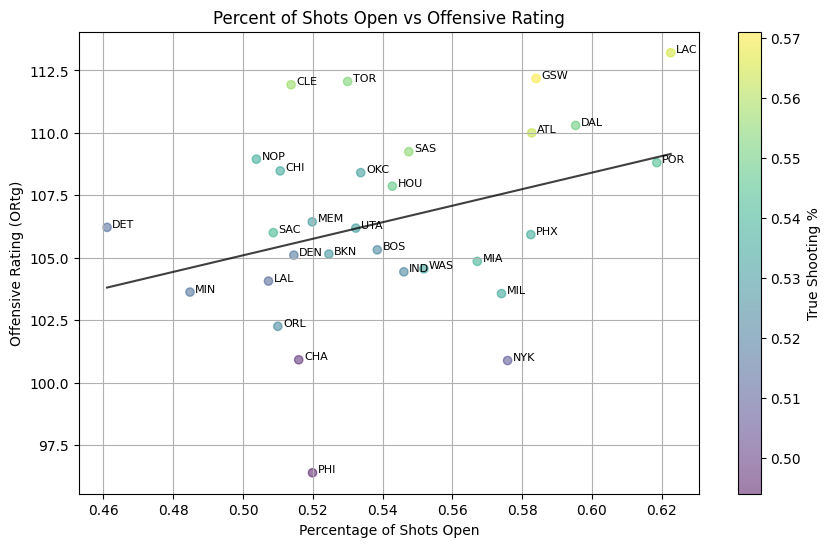

In [6]:
# Extracting x, y, and color values
x = offense_summary['pct_shots_open']
y = offense_summary['ORtg']
colors = offense_summary['TS%']

# Calculate the trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
trendline = intercept + slope * x

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, alpha=0.5, c=colors, cmap='viridis')

# Plot the trendline
plt.plot(x, trendline, 'k-', alpha=0.75)

# Add team codes as labels with an offset
offset = 0.0015
for i, txt in enumerate(offense_summary['team_code']):
    plt.text(x.iloc[i] + offset, y.iloc[i] + offset, txt, fontsize=8)

# Plot styling
plt.title('Percent of Shots Open vs Offensive Rating')
plt.xlabel('Percentage of Shots Open')
plt.ylabel('Offensive Rating (ORtg)')
plt.colorbar(scatter, label='True Shooting %')
plt.grid(True)
plt.show()

The goal of this analysis is to explore how open shots contribute to offensive success. The table shows the 5 teams that generate the highest percent of open shots in the NBA. These include offensive powerhouses like the Clippers, Warriors, and Mavericks. The scatterplot shows the relationship between percentage of open shots and offensive rating (the number of points per 100 possessions), colored by a team's shooting efficiency. The plot shows a fairly strong, positive relationship between the variables, highlighting the importance of generating such looks for offensive efficiency. However, there are notable exceptions: teams like Cleveland and Toronto produce a fairly average number of open looks, but still rank at the top of the league in offensive rating. This shows that there is still randomness in the outcomes, even when controlling for how good of looks a team produces.

In [7]:
# Get percent of open shots for each defense
defense_summary = open_shots_df.groupby('def_team_code').agg(
    fga=('fgm', 'count'),
    fgm=('fgm', 'sum'),
    open_shots=('open_shot', 'sum')
).assign(
    fg_pct=lambda x: x['fgm'] / x['fga'],
    pct_shots_open=lambda x: x['open_shots'] / x['fga']
).sort_values(by='pct_shots_open', ascending=True)

# Add team defensive ratings
defense_summary = defense_summary.merge(
    team_ratings_df[['Code', 'DRtg']],
    left_on='def_team_code',
    right_on='Code',
    how='left'
)

# Add opponent true shooting percentage
defense_summary = defense_summary.merge(
    team_shooting_df[['Team', 'Opp_TS%']],
    left_on='Code',
    right_on='Team',
    how='left'
)

# Drop 'Team' column and rename 'Code' column
defense_summary = defense_summary.drop(columns=['Team'])
defense_summary = defense_summary.rename(columns={'Code': 'team_code'})

# Reorder columns
defense_summary = defense_summary[[
    'team_code', 'fga', 'fgm', 'fg_pct', 'open_shots', 'pct_shots_open', 'DRtg', 'Opp_TS%'
]]

# Display the first few rows of the DataFrame
defense_summary.head()

,team_code,fga,fgm,fg_pct,open_shots,pct_shots_open,DRtg,Opp_TS%
0,SAS,4396,1951,0.443813,2139,0.486579,102.61,0.521
1,PHX,4543,2062,0.453885,2250,0.495267,106.85,0.539
2,NOP,4331,1993,0.460171,2214,0.511198,108.15,0.533
3,CHI,4512,2028,0.449468,2314,0.512855,105.11,0.510
4,POR,4515,1958,0.433666,2325,0.514950,104.30,0.513


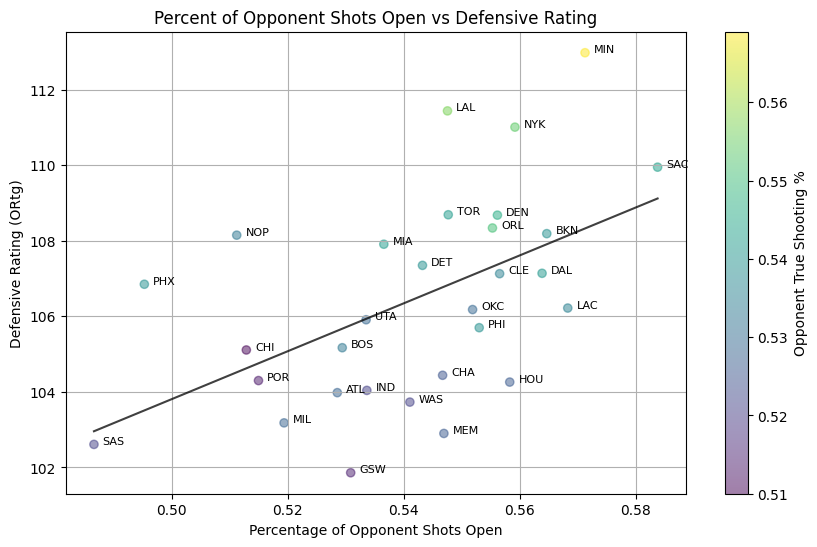

In [8]:
# Extracting x, y, and color values
x = defense_summary['pct_shots_open']
y = defense_summary['DRtg']
colors = defense_summary['Opp_TS%']

# Calculate the trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
trendline = intercept + slope * x

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, alpha=0.5, c=colors, cmap='viridis')

# Plot the trendline
plt.plot(x, trendline, 'k-', alpha=0.75)

# Add team codes as labels with an offset
offset = 0.0015
for i, txt in enumerate(defense_summary['team_code']):
    plt.text(x.iloc[i] + offset, y.iloc[i] + offset, txt, fontsize=8)

# Plot styling
plt.title('Percent of Opponent Shots Open vs Defensive Rating')
plt.xlabel('Percentage of Opponent Shots Open')
plt.ylabel('Defensive Rating (ORtg)')
plt.colorbar(scatter, label='Opponent True Shooting %')
plt.grid(True)
plt.show()

On the opposite end, the above table and scatterplot explore how preventing open looks contributes to defensive success. The table shows the 5 teams with the fewest percent of open shots allowed. Teams with great defenses such as the Spurs, Trailblazers, and Bulls show up on this list. Looking at the entire league, the scatterplot shows the percentage of open shots allowed by the opponent against the team's defensive rating, and colored by opponent shooting efficiency. This plot shows a strong relationship between contesting shots and defensive strength, as indicated by the downward sloping line. It seems that the relationship is stronger on the right-side of the graph, where teams who allow the most open looks have the worst defensive ratings. On the left-side, there is more randomness and the teams are more widely distributed.

Note: Generative AI was used to complete this notebook.